In [26]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import networkx as nx
from fastconsensus.core import construct_sparse_consensus_matrix,threshold_matrix,triadic_closure,check_convergence,get_algorithm
import igraph as ig
import os
from neuromaps.datasets import fetch_annotation
from bct.algorithms.centrality import participation_coef, module_degree_zscore
from neuromaps import transforms
from nibabel import freesurfer as fs

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(ggsegGlasser)
    library(ggseg)
    library(LaCroixColoR)
    library(patchwork)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

# Load Louvain clustering results
### Code already run separately in Peripheral/louvain_parameter_sweep.py

In [6]:
data_path = "/Users/abry4213/data/OCDA/"

# Load brain region labels
brain_regions = pd.read_csv("../data/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI']).drop('node', axis=1)
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

# Filter to node_index<=180 and drop node_index 92
brain_regions = brain_regions[brain_regions['node_index']<=180]
brain_regions = brain_regions[brain_regions['node_index']!=92]

louvain_gamma_range = np.arange(0.5, 2.01, 0.1)
louvain_sweep_res_list = []
for gamma_val in louvain_gamma_range:
    # Use string formatting to two decimal places
    gamma_val_str = "{:.1f}".format(gamma_val)
    louvain_modules = (pd.read_csv(f"{data_path}/Louvain_results/Louvain_Rubinov_assignments_100reps_gamma{gamma_val_str}.csv", header=None))

    # Sweep across each column and find the number of unique values
    num_modules_this_gamma = louvain_modules.apply(lambda x: len(x.unique()), axis=0)

    mean_num_modules = num_modules_this_gamma.mean()
    std_num_modules = num_modules_this_gamma.std()
    this_gamma_df = pd.DataFrame({'gamma_val': gamma_val, 'mean_num_modules': mean_num_modules, 'sd_num_modules': std_num_modules}, index=[0])
    louvain_sweep_res_list.append(this_gamma_df)

louvain_sweep_res_df = pd.concat(louvain_sweep_res_list, axis=0)

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


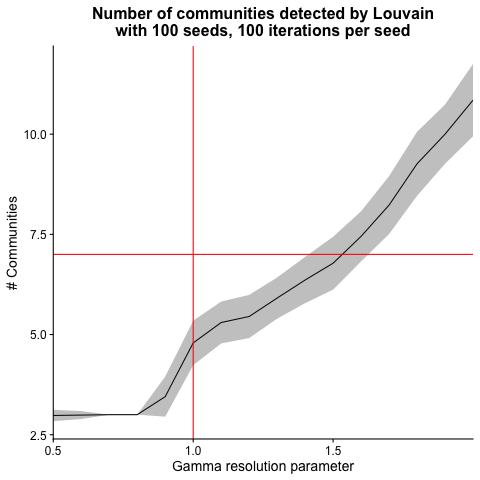

In [9]:
%%R -i louvain_sweep_res_df

louvain_sweep_res_df %>%
    ggplot(data=., mapping=aes(x=gamma_val, y=mean_num_modules)) +
    geom_line() +
    geom_ribbon(aes(ymin=mean_num_modules-sd_num_modules, ymax=mean_num_modules+sd_num_modules), alpha=0.3) +
    geom_vline(xintercept=1, color="red") +
    geom_hline(yintercept=7, color="red") +
    scale_x_continuous(expand=c(0,0)) +
    ylab("# Communities") +
    xlab("Gamma resolution parameter") +
    ggtitle("Number of communities detected by Louvain\nwith 100 seeds, 100 iterations per seed") +
    theme(plot.title = element_text(hjust=0.5))
# ggsave("../plots/Louvain_num_communities_by_gamma.svg", width=5, height=4, dpi=300, units="in")

### Seed--seed ENMI at gamma=1

In [13]:
target_gamma = '1.0'

NMI_results_sweep_across_seeds = (pd.read_csv(f"{data_path}/Louvain_results/NMI_results_sweep_across_seeds_{target_gamma}.csv", 
                                                     header=None, 
                                                     names=['target_seed', 'comparison_seed', 'NMI'])
)

mean_NMI_by_seed = NMI_results_sweep_across_seeds.query("comparison_seed != target_seed").groupby('comparison_seed')['NMI'].mean().reset_index()

In addition: Warning messages:
1: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?
2: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?


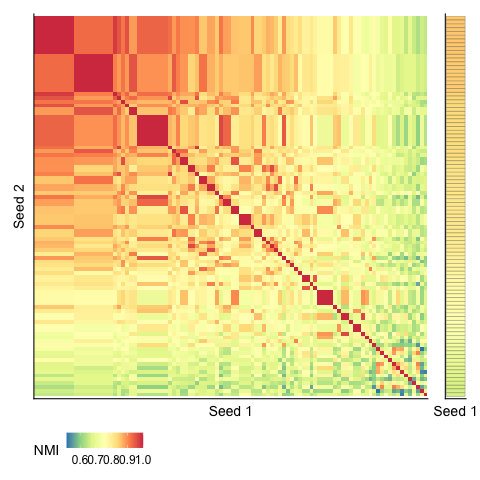

In [14]:
%%R -i NMI_results_sweep_across_seeds,mean_NMI_by_seed

seed_order <- mean_NMI_by_seed %>% arrange(desc(NMI)) %>% pull(comparison_seed)

heatmap_min <- min(NMI_results_sweep_across_seeds$NMI)
heatmap_max <- max(NMI_results_sweep_across_seeds$NMI)

heatmap_plot <- NMI_results_sweep_across_seeds %>% 
    mutate(target_seed = factor(target_seed, levels=seed_order),
           comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=target_seed, y=comparison_seed, fill=NMI)) +
    geom_tile() +
    scale_fill_distiller(palette="Spectral") +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

bar_plot <- mean_NMI_by_seed %>%
    mutate(comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=0, y=comparison_seed, fill=NMI)) +
    geom_tile(color='black') +
    scale_fill_distiller(palette="Spectral", limits=c(heatmap_min, heatmap_max)) +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

wrap_plots(list(heatmap_plot, bar_plot), ncol=2, widths=c(0.95, 0.05)) + 
    plot_layout(guides = "collect",axis_titles = "collect_y") & 
    theme(legend.position = 'bottom')
# ggsave("../plots/Louvain_gamma1_NMI.svg", width=6, height=5, dpi=300, units="in")

## Final solution: seed 98 with gamma=1.00

In [14]:
final_louvain_res = ((pd.read_csv(f"{data_path}/Louvain_results/Louvain_Rubinov_assignments_100reps_gamma1.00.csv", 
                                 names=np.arange(1, 101)))[[98]]
                                 .rename(columns={98: 'Louvain_community'})
                                 .assign(node_index=brain_regions.node_index.values)
                                 .merge(brain_regions, on='node_index')
)

# Save to csv
final_louvain_res.to_csv("../data/louvain_community_assignments_BCT_gamma1.csv", index=False)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


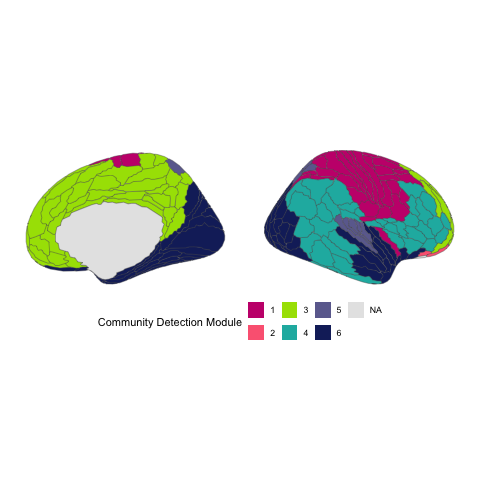

In [15]:
%%R -i final_louvain_res

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
}

# Tidy data
final_louvain_res <- final_louvain_res %>% 
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", ""))%>% 
  dplyr::rename("label" = "Glasser_RH_ROI")

# Merge modules + Glasser data
modules_in_glasser_atlas <- final_louvain_res %>% 
  left_join(., glasser_lookup_table) %>%
  arrange(Louvain_community)

# Plot modules on cortical surface with Glasser parcellation
modules_in_glasser_atlas %>%
  mutate(Louvain_community = as.factor(Louvain_community)) %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Louvain_community),
             hemi = "right") +
  theme_void()  + 
  scale_fill_manual(values=lacroix_palette("PassionFruit", 6), na.value="gray90") +
  labs(fill = "Community Detection Module") +
  theme(legend.position="bottom")
# ggsave("../plots/Louvain_gamma1_in_brain.svg", width=6, height=5, dpi=300, units="in")

### Robustness test: Seed--seed ENMI at gamma=1.5

In [15]:
target_gamma_robustness = '1.5'

NMI_results_sweep_across_seeds_robustness = (pd.read_csv(f"{data_path}/Louvain_results/NMI_results_sweep_across_seeds_{target_gamma_robustness}.csv", 
                                                     header=None, 
                                                     names=['target_seed', 'comparison_seed', 'NMI'])
)

mean_NMI_by_seed_robustness = NMI_results_sweep_across_seeds_robustness.query("comparison_seed != target_seed").groupby('comparison_seed')['NMI'].mean().reset_index()

In addition: Warning messages:
1: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?
2: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?


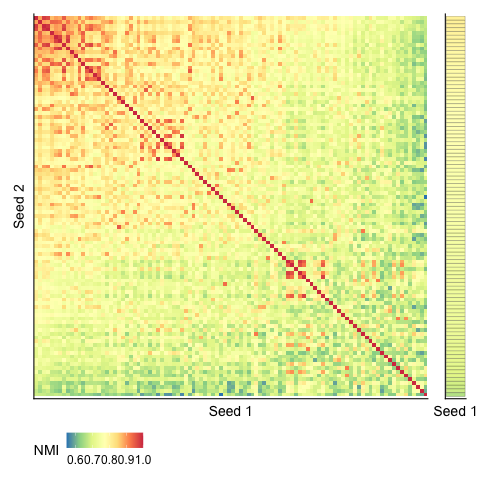

In [16]:
%%R -i NMI_results_sweep_across_seeds_robustness,mean_NMI_by_seed_robustness

seed_order <- mean_NMI_by_seed_robustness %>% arrange(desc(NMI)) %>% pull(comparison_seed)

heatmap_min <- min(NMI_results_sweep_across_seeds_robustness$NMI)
heatmap_max <- max(NMI_results_sweep_across_seeds_robustness$NMI)

heatmap_plot <- NMI_results_sweep_across_seeds_robustness %>% 
    mutate(target_seed = factor(target_seed, levels=seed_order),
           comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=target_seed, y=comparison_seed, fill=NMI)) +
    geom_tile() +
    scale_fill_distiller(palette="Spectral") +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

bar_plot <- mean_NMI_by_seed_robustness %>%
    mutate(comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=0, y=comparison_seed, fill=NMI)) +
    geom_tile(color='black') +
    scale_fill_distiller(palette="Spectral", limits=c(heatmap_min, heatmap_max)) +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

wrap_plots(list(heatmap_plot, bar_plot), ncol=2, widths=c(0.95, 0.05)) + 
    plot_layout(guides = "collect",axis_titles = "collect_y") & 
    theme(legend.position = 'bottom')
# ggsave("../plots/Louvain_gamma1_NMI.svg", width=6, height=5, dpi=300, units="in")

## Final solution: seed 91 with gamma=1.4

In [17]:
final_louvain_res_robustness = ((pd.read_csv(f"{data_path}/Louvain_results/Louvain_Rubinov_assignments_100reps_gamma1.5.csv", 
                                 names=np.arange(1, 101)))[[91]]
                                 .rename(columns={91: 'Louvain_community'})
                                 .assign(node_index=brain_regions.node_index.values)
                                 .merge(brain_regions, on='node_index')
)

# Save to csv
final_louvain_res_robustness.to_csv("../data/louvain_community_assignments_BCT_gamma1.5_seed91.csv", index=False)

In [20]:
%%R -i final_louvain_res_robustness

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
}

# Tidy data
final_louvain_res_robustness <- final_louvain_res_robustness %>% 
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", ""))%>% 
  dplyr::rename("label" = "Glasser_RH_ROI")

# Merge modules + Glasser data
modules_in_glasser_atlas <- final_louvain_res_robustness %>% 
  left_join(., glasser_lookup_table) %>%
  arrange(Louvain_community)

# Plot modules on cortical surface with Glasser parcellation
modules_in_glasser_atlas %>%
  mutate(Louvain_community = as.factor(Louvain_community)) %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Louvain_community),
             hemi = "right") +
  theme_void()  + 
  scale_fill_manual(values=lacroix_palette("PassionFruit", 7), na.value="gray90") +
  labs(fill = "Community Detection Module") +
  theme(legend.position="bottom")
ggsave("../plots/Louvain_gamma1.5_in_brain.svg", width=6, height=5, dpi=300, units="in")

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


# Create same plots as in main analysis, but for gamma=1.5

In [27]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices
glasser180_right_ctab = glasser180_right_ctab
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_PG1 = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_PG1_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG1, '164k', 'R')[0]
margulies_PG1_fsaverage_right_vertices = margulies_PG1_fsaverage_right.agg_data()

margulies_PG2 = fetch_annotation(source='margulies2016', desc='fcgradient02')
margulies_PG2_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG2, '164k', 'R')[0]
margulies_PG2_fsaverage_right_vertices = margulies_PG2_fsaverage_right.agg_data()

# Combine PG1 and PG2 across vertices
margulies_PG_fsaverage_right_df = pd.DataFrame({'PG1_value': margulies_PG1_fsaverage_right_vertices, 
                                                'PG2_value': margulies_PG2_fsaverage_right_vertices, 
                                                'vertex_number': np.arange(0, len(margulies_PG1_fsaverage_right_vertices))})

# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_PG_fsaverage_right_df, on='vertex_number', how='left')

# Compute the mean PG1/PG2 values by region
mean_PG_value_by_region = (merged_df
                            .groupby(['Glasser_RH_ROI'])[['PG1_value', 'PG2_value']]
                            .mean()
                            .reset_index()
                            .merge(oslom_modules_final_glasser180_right, how='left'))

# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])
oslom_modules_final_glasser180_right_long = pd.read_csv(f"../data/OSLOM30_final_module_assignments_with_duplicates.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

# Define data path
data_path = "/Users/abry4213/data/OCDA/"

# Convert oslom_modules_final_glasser180_right_long to a wide format, with each row correspoding to a region and each column to a module
# Values should be 1 if the region is in the module, 0 otherwise
oslom_modules_final_glasser180_right_wide = oslom_modules_final_glasser180_right_long.assign(value=1).pivot(index='Glasser_RH_ROI', columns='module', values='value').fillna(0)
oslom_modules_final_glasser180_right_wide.to_csv("../data/OSLOM30_final_module_assignments_wide_binary.csv", index=False, header=False)

# Load brain region labels
brain_regions = pd.read_csv("../data/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI']).drop('node', axis=1)
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

# Filter to node_index<=180 and drop node_index 92
brain_regions = brain_regions[brain_regions['node_index']<=180]
brain_regions = brain_regions[brain_regions['node_index']!=92]

# Load brain region names
region_names = brain_regions.Glasser_RH_ROI.values

# Loading community structure as determined by Louvain
louvain_consensus_results = pd.read_csv("../data/louvain_community_assignments_BCT_gamma1.5_seed91.csv").assign(Glasser_RH_ROI=region_names)

# Load right-hemisphere connectivity matrix
RH_connectivity_data = pd.DataFrame(scipy.io.loadmat('../data/RH.mat')['RH'])

# Drop column/row 91
RH_connectivity_data = RH_connectivity_data.drop(index=91, columns=91)

# Assign region names to rows and columns
RH_connectivity_data.index = region_names
RH_connectivity_data.columns = region_names

# Load right-hemisphere connectivity matrix, with added nodes for OSLOM overlap
RH_connectivity_data_overlap = pd.DataFrame(scipy.io.loadmat('../data/RH_with_OSLOM_duplicates.mat')['RH_with_repeats'])

# Load results with duplicates for OSLOM
oslom_modules_final_glasser180_right = pd.read_csv("../data/OSLOM30_final_module_assignments.csv")
oslom_modules_final_glasser180_right_long = pd.read_csv("../data/OSLOM30_final_module_assignments_with_duplicates.csv")
oslom_modules_final_glasser180_right_long = oslom_modules_final_glasser180_right_long.merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping']], on='Glasser_RH_ROI', how='left')


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cort

In [30]:
%%R -i region_names,oslom_modules_final_glasser180_right,louvain_consensus_results -o oslom_modules_final_glasser180_right,louvain_consensus_results

oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>% 
    arrange(Glasser_RH_ROI)

louvain_consensus_results <- louvain_consensus_results %>%
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>%
    arrange(Glasser_RH_ROI)

## Compute participation coefficient (P) and module degree, z-scored (Z)

In [31]:
louvain_P = participation_coef(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
oslom_P = participation_coef(RH_connectivity_data_overlap.values, oslom_modules_final_glasser180_right_long['module'].values)

louvain_Z = module_degree_zscore(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
oslom_Z = module_degree_zscore(RH_connectivity_data_overlap.values, oslom_modules_final_glasser180_right_long['module'].values)

louvain_structure_df = (louvain_consensus_results
                        .merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping', 'module']], 
                               on="Glasser_RH_ROI", how="left")
                        .assign(louvain_P=louvain_P, louvain_Z=louvain_Z)
                        .rename(columns={'module': 'OSLOM_module'})
                        )

oslom_structure_df = (oslom_modules_final_glasser180_right_long
                      .assign(oslom_P = oslom_P, oslom_Z = oslom_Z)
                      )

### Plot Z vs. P for Louvain

In [33]:
%%R -i louvain_structure_df,module_orders,oslom_structure_df

z_min <- min(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
z_max <- max(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
p_min <- min(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))
p_max <- max(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

louvain_structure_df %>% 
    mutate(row_index = row_number()) %>%
    mutate(color_module = ifelse(overlapping=='overlapping', OSLOM_module, NA_character_)) %>%
    ggplot(data=., mapping=aes(x=louvain_P, y=louvain_Z, color=color_module)) +
    geom_vline(xintercept=0, linetype='dashed') +
    geom_hline(yintercept=0, linetype='dashed') +
    scale_x_continuous(limits=c(p_min, p_max)) +
    scale_y_continuous(limits=c(z_min, z_max)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray80") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
ggsave("../Plots/Louvain_community_stats_gamma1.5.svg", width=4, height=4.5, units="in", dpi=300)

## Compare p/Z in Louvain vs. OSLOM space

In [35]:
P_z_data_to_plot_all = (oslom_structure_df[['Glasser_RH_ROI', 'oslom_P', 'oslom_Z']]
                  .merge(louvain_structure_df[['Glasser_RH_ROI', 'louvain_P', 'louvain_Z']], 
                         on='Glasser_RH_ROI', how='left')
                    .assign(P_diff = lambda x: x.oslom_P - x.louvain_P,
                                Z_diff = lambda x: x.oslom_Z - x.louvain_Z)
                    .merge(louvain_structure_df, on=['Glasser_RH_ROI', 'louvain_P', 'louvain_Z'])
                                )

# Filter to overlapping regions and then to the instance with the max |Z_diff
P_z_data_to_plot = P_z_data_to_plot_all.query("overlapping == 'overlapping'").groupby('Glasser_RH_ROI').apply(lambda x: x.loc[abs(x.Z_diff).idxmax()])

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_4045/4131179278.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  P_z_data_to_plot = P_z_data_to_plot_all.query("overlapping == 'overlapping'").groupby('Glasser_RH_ROI').apply(lambda x: x.loc[abs(x.Z_diff).idxmax()])


In [37]:
%%R -i P_z_data_to_plot,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

P_z_data_to_plot %>% 
    mutate(label_short = gsub("R_|_ROI", "", Glasser_RH_ROI)) %>%
    group_by(label_short) %>% 
    ggplot(data=., mapping=aes(x=P_diff, y=Z_diff, color=OSLOM_module)) +
    geom_hline(yintercept=0, linetype="dashed", linewidth=0.4) +
    geom_vline(xintercept=0, linetype="dashed", linewidth=0.4) +
    geom_point(size=1.7) +
    # geom_text(aes(label=label_short), size=2, nudge_y=0.1) +
    ylab("Change in Within-module strength, z") +
    xlab("Change in Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray90") +
    theme(legend.position="bottom",
            axis.title = element_text(size=16),
            axis.text = element_text(size=14),
            legend.title=element_blank())
ggsave("../Plots/Delta_P_vs_z_partitions_gamma1.5.svg", width=3, height=4, units="in", dpi=300)

## Compare 9m/8BM community assignment in Louvain vs. OSLOM

In [38]:
# What region do we want? ProS
target_regions_to_plot = ["R_9m_ROI", "R_8BM_ROI"]

# Find the indices of these names in region_names array as an array
target_region_indices = np.where(np.isin(region_names, target_regions_to_plot))[0]

# Keep all edges that connect to node 127 (with base 0, after removing node 92, that's node 125 in Python)
RH_connectivity_arr = np.array(RH_connectivity_data)
keepNodes = RH_connectivity_arr[target_region_indices, :] > 0

# Keep just the connected nodes
keepNodes = np.any(keepNodes, axis=0)
keepNodes_indices = np.where(keepNodes)[0] + 1

# Subset RH_connectivity_arr rows and columns to only the indices in keepNode that are 1
RH_connectivity_arr_sub = RH_connectivity_arr[keepNodes, :][:, keepNodes]
numNodes = RH_connectivity_arr_sub.shape[0]

# Subset OSLOM results to only include nodes in the subnetwork
oslom_structure_df_connected_subset = oslom_structure_df.query("node in @keepNodes_indices").drop(columns=['node']).drop_duplicates(subset=["Glasser_RH_ROI"]).assign(node_index = lambda x: range(len(x.module)))

# Subset region_labels to only include nodes in the subnetwork
region_names_sub = [d for d, m in zip(region_names, keepNodes) if m]

# Convert to a dataframe
region_names_sub = pd.DataFrame(region_names_sub, columns=['Glasser_RH_ROI'])
region_names_sub['index_sub'] = range(len(region_names_sub))
target_region_index_sub = region_names_sub.query("Glasser_RH_ROI in @target_regions_to_plot").index_sub.values

# Filter community assignments to only include nodes in the subnetwork
oslom_subset = oslom_modules_final_glasser180_right.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))
louvain_subset = louvain_structure_df.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))

### Plot Louvain structure for 8BM + 9m

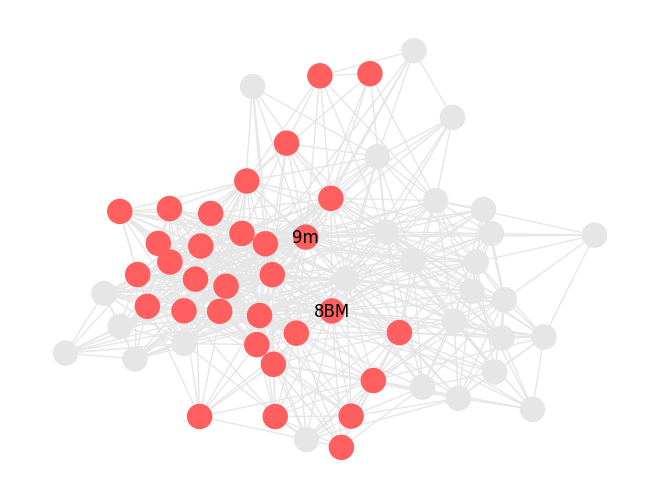

In [45]:
louvain_community_with_8BM_9m = louvain_subset.query("Glasser_RH_ROI in @target_regions_to_plot").Louvain_community.values[0]
# Highlighting the nodes belonging to community 0 which is split into several communities by OSLOM
nodes_louvain_8BM_9m_cluster = louvain_subset.query("Louvain_community == @louvain_community_with_8BM_9m").node_index.tolist()
nodes_louvain_other = louvain_subset.query("Louvain_community != @louvain_community_with_8BM_9m").node_index.tolist()

# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_louvain = nx.Graph(RH_connectivity_arr_sub)

# Get short names
region_names_sub_short = region_names_sub.Glasser_RH_ROI.str.replace("R_", "").str.replace("_ROI", "").values

# Color nodes by community in G
labels = {}    
color_map = []
for node in G_louvain:
    if node in target_region_index_sub:
        labels[node] = region_names_sub_short[node]
    if node in nodes_louvain_8BM_9m_cluster:
        color_map.append('#FF5F5E')
    else: 
        color_map.append('#E6E6E6')      
nx.draw(G_louvain, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
plt.savefig("../Plots/Louvain_9m_8BM_network_graph_gamma1.5.svg", format="SVG")

### Do PG1 values relate to OSLOM z/P?

In [40]:
PG_values_vs_nodal_stats = (mean_PG_value_by_region
                            .merge(oslom_structure_df.drop(['module', 'overlapping'], axis=1), on=['Glasser_RH_ROI'], how='left')
                            .query("overlapping == 'overlapping'")
                            .drop_duplicates(subset=['Glasser_RH_ROI', 'PG1_value', 'oslom_P'])
                            .merge(louvain_structure_df[['Glasser_RH_ROI', 'louvain_P', 'louvain_Z']], on=['Glasser_RH_ROI'], how='left')
)

In [44]:
%%R -i PG_values_vs_nodal_stats,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

PG_values_vs_nodal_stats %>% 
    pivot_longer(cols=c("louvain_P", "oslom_P"), names_to="Partitioning", values_to="P") %>%
    filter(Partitioning=="louvain_P") %>%
    ggplot(data=., mapping=aes(y=PG1_value, x=P))  +
    geom_smooth(method="lm", se=FALSE, color="black") +
    facet_grid(Partitioning ~ ., scales="free_y") +
    ggpubr::stat_cor(method="spearman", label.x=0.5, label.y=6, label.sep="\n", cor.coef.name = 'rho') +
    geom_point(aes(color=module)) +
    scale_color_manual(values=colormap) +
    xlab("Participation Coefficient, P") +
    ylab("Mean PG1 value") +
    theme(legend.position="none",
          axis.text = element_text(size=14))
ggsave("../Plots/PG1_vs_P_Louvain_overlapping_regions_gamma1.5.svg", width=3.25, height=3, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'
